# Objective

The objective of this notebook is to perform sentiment analysis on a dataset consisting of restraunt reviews about 1920 datapoints.
We will be using scikit-learn library to perform this sentiment analysis. The feature extraction is done using TF-IDF vectorization which is then lemmatized using nltk. To find the best model a gridsearch method is used with different hyperparameters. Best model is usde to perfrom the sentiment analysis.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
from sklearn import preprocessing, metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('brown')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vishu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Vishu\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vishu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Transformation and Manipulation

In [2]:
# Data is imported
data=pd.read_csv('reviews.csv', delimiter='\t')

In [3]:
data.head(10)

,Name,RatingValue,DatePublished,Review
0,Playa Cabana,4,2020-02-26,I was tasked with finding a spot for a group d...
1,Playa Cabana,3,2019-08-04,Went here with my friends and family. I liked ...
2,Playa Cabana,3,2019-08-24,Surprisingly good Flautas! They came as 3 roll...
3,Playa Cabana,4,2019-06-06,As a Mexican I always crave authentic Mexican ...
4,Playa Cabana,5,2020-05-25,Best tacos I've ever had. Both locations are g...
5,Playa Cabana,4,2019-08-31,Food was exceptional and service was pretty fa...
6,Playa Cabana,4,2019-04-07,"Their space is a bit cramped, but Playa Cabana..."
7,Playa Cabana,4,2019-01-16,"Okay, so I found my new favourite Latin spot. ..."
8,Playa Cabana,4,2019-12-12,Went last week. Food is very good! Churros wer...
9,Playa Cabana,4,2019-01-12,Yes all day er'rday to their chips -- they mak...


In [4]:
data['Review'][1]

'Went here with my friends and family. I liked the spice side fillings and their lobster tacos was good I heard. I had the veggie enchiladas and was alright. Even the veggie tostadas was good. However, I feel the food was expensive for the food quality.\nWe got the \nNachos  - small but good\nGuacamole and chips - good needed some spice \nChicken wings - so so \nVeggie enchiladas - was so so \nVeggie burrito - good \nVeggie tostados - good\nShrimp enchiladas - was so so \nLobster tacos - very good \nFish tacos - very good \nPork tacos - was so so'

###  Rating Value Conversion    
Create a new array for representation of rating in a 2-D ndarray.

5    828
4    637
3    297
2     86
1     72
Name: RatingValue, dtype: int64 




<AxesSubplot:xlabel='RatingValue', ylabel='count'>

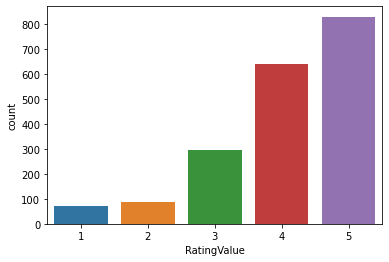

In [5]:
print(data.RatingValue.value_counts(),'\n\n')
sns.countplot(x='RatingValue', data=data)

The 5 classes are reduced to only three classes (Negative, Positive and Neutral)

In [6]:
temp_target=np.empty([len(data), 1], dtype='U8')
for review_row in data.itertuples():
    if review_row[2] in [1,2]:
        temp_target[review_row[0],0]='Negative'
    elif review_row[2] ==3:
        temp_target[review_row[0],0]='Neutral'
    else :
       temp_target[review_row[0],0]='Positive'

data['RatingValue']=temp_target

Positive    1465
Neutral      297
Negative     158
Name: RatingValue, dtype: int64 




<AxesSubplot:xlabel='RatingValue', ylabel='count'>

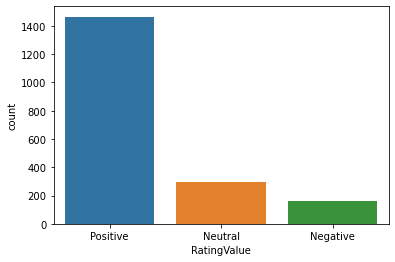

In [7]:
print(data.RatingValue.value_counts(),'\n\n')
sns.countplot(x='RatingValue', data=data)

## Undersampling the Neutral and Positive Reviews to match the Negative

Since we want to train our model on a balanced data. This step is necessary even though it reduces the data. A skewed trained model is a bigger issue.

In [8]:
pos_count, neut_count, neg_count = data.RatingValue.value_counts()

neg_review= data[data['RatingValue']=='Negative']
pos_review= data[data['RatingValue']=='Positive']
neut_review= data[data['RatingValue']=='Neutral']

# Undersample the Positive and Neutral Review randomly
pos_review_under= pos_review.sample(neg_count)
neut_review_under= neut_review.sample(neg_count)

data_under=pd.concat([neg_review,pos_review_under,neut_review_under])

#Shuffle the indexes and the concatenated result
data_under=data_under.sample(frac=1).reset_index(drop=True)


Positive    158
Neutral     158
Negative    158
Name: RatingValue, dtype: int64 




<AxesSubplot:xlabel='RatingValue', ylabel='count'>

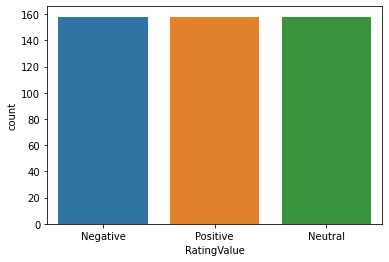

In [9]:
print(data_under.RatingValue.value_counts(),'\n\n')
sns.countplot(x='RatingValue', data=data_under)

## Lemmatizer Class

Lemmatizer is defined in this class to be further used in the pipeline when we process the data for training.

In [10]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

### Splitting into train and test dataset.

In [11]:
review_train, review_val, rating_train, rating_val=train_test_split(data_under['Review'], data_under['RatingValue'], test_size=0.2)

# Create train.csv
train_csv=pd.DataFrame({'Review':review_train, 'RatingValue':rating_train})
train_csv.to_csv('train.csv',index=False, escapechar='\n')

## Create Valid.csv
val_csv=pd.DataFrame({'Review':review_val, 'RatingValue':rating_val})
val_csv.to_csv('valid.csv',index=False, escapechar='\n')

### Initialize the Pipeline

In [12]:
text_clf = Pipeline([('vect', CountVectorizer(tokenizer=LemmaTokenizer())),('tfidf', TfidfTransformer()),('clf', LinearSVC()),])

### Gridsearch

The hyperparameters to be used in the gridsearch are defined first.
Then the gridsearch is performed, which is followed with the best model parameters.

In [13]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__loss': ('hinge','squared_hinge'),
    'clf__max_iter': (500, 1000),
}

In [14]:
## Grid Search with Cross validations fivefold, all cores are used for training
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(review_train, rating_train)

## Best Model Statistics
print(gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.6598947368421053
clf__loss: 'squared_hinge'
clf__max_iter: 500
tfidf__use_idf: True
vect__max_df: 1.0
vect__ngram_range: (1, 2)


## Predicitions and Inference

The best model selected from the gridsearch is further used to make the predictions on the testing dataset. Followed by the classification report and the confusion matrix.

In [33]:
### Best Model is used to Predict the Sentiment of the Test Data i.e review_val
pred=gs_clf.predict(review_val)
conf=metrics.confusion_matrix(rating_val,pred)

In [34]:
print(accuracy_score(rating_val, pred), ": Accuracy on the test set")
print(f1_score(rating_val, pred, average='macro'),
      ": F1-score on the test set\n")

print("\t "+"negative", "\t", "neutral"+"\t", "positive"+"\t\n", "negative   ",
      conf[0][0], "\t   ", conf[0][1], "\t\t   ", conf[0][2],
      "\n neutral    ", conf[1][0], "\t   ", conf[1][1], "\t\t   ",
      conf[1][2], "\n positive   ", conf[2][0], "\t\t   ", conf[2][1],
      "\t\t   ", conf[2][2])
      
print(metrics.classification_report(rating_val, pred))

0.6947368421052632 : Accuracy on the test set
0.7016928594753754 : F1-score on the test set

	 negative 	 neutral	 positive	
 negative    26 	    11 		    4 
 neutral     7 	    21 		    2 
 positive    0 		    5 		    19
              precision    recall  f1-score   support

    Negative       0.79      0.63      0.70        41
     Neutral       0.57      0.70      0.63        30
    Positive       0.76      0.79      0.78        24

    accuracy                           0.69        95
   macro avg       0.71      0.71      0.70        95
weighted avg       0.71      0.69      0.70        95

